# Why R Conference? Introduction to mlr

## Resampling

We will continue our example for spam classification

a) Instead of manually splitting train and test set create a holdout set directly in mlr. Use the set to evaluate the performance of an algorithm of your choice on the spam data. Use 80% of the data for training and create stratified splits.

In [2]:
library(mlr)
data(spam, package = "kernlab")
spam.task = makeClassifTask(data = spam, target = "type")
lrn = makeLearner("classif.rpart", predict.type = "prob")


b) Now create a 10-fold crossvalidation and evaluate AUC and training time

In [8]:
resample(lrn, spam.task, cv10, measures = list(auc, timetrain))

Resampling: cross-validation
Measures:             auc         timetrain   
[Resample] iter 1:    0.8629      0.2080      
[Resample] iter 2:    0.9015      0.0880      
[Resample] iter 3:    0.8920      0.0950      
[Resample] iter 4:    0.8746      0.0770      
[Resample] iter 5:    0.9095      0.1930      
[Resample] iter 6:    0.8981      0.0940      
[Resample] iter 7:    0.8812      0.1820      
[Resample] iter 8:    0.9100      0.0760      
[Resample] iter 9:    0.8867      0.0800      
[Resample] iter 10:   0.9134      0.0760      


Aggregated Result: auc.test.mean=0.8930,timetrain.test.mean=0.1169




Resample Result
Task: spam
Learner: classif.rpart
Aggr perf: auc.test.mean=0.8930,timetrain.test.mean=0.1169
Runtime: 1.48959

## Benchmarking

We would like to create a small benchmark study to see how much complexity is required to achieve an AUC of at least 98%.

a) Create the following learning algorithms to compare their performance
- Featureless baseline learner
- Linear Discriminant Analysis
- Logistic Regression
- Classification Tree
- Random Forest

In [12]:
lrns = makeLearners(type = "classif", c("featureless", "lda", "logreg", "rpart", 
                                        "randomForest"), predict.type = "prob")
lrns

$classif.featureless
Learner classif.featureless from package mlr
Type: classif
Name: Featureless classifier; Short name: featureless
Class: classif.featureless
Properties: twoclass,multiclass,numerics,factors,ordered,missings,prob,functionals
Predict-Type: prob
Hyperparameters: 


$classif.lda
Learner classif.lda from package MASS
Type: classif
Name: Linear Discriminant Analysis; Short name: lda
Class: classif.lda
Properties: twoclass,multiclass,numerics,factors,prob
Predict-Type: prob
Hyperparameters: 


$classif.logreg
Learner classif.logreg from package stats
Type: classif
Name: Logistic Regression; Short name: logreg
Class: classif.logreg
Properties: twoclass,numerics,factors,prob,weights
Predict-Type: prob
Hyperparameters: model=FALSE


$classif.rpart
Learner classif.rpart from package rpart
Type: classif
Name: Decision Tree; Short name: rpart
Class: classif.rpart
Properties: twoclass,multiclass,missings,numerics,factors,ordered,prob,weights,featimp
Predict-Type: prob
Hyperparame

b) Benchmark the five learning algorithms with a 5-fold crossvalidation (ensure identical folds for all learners). Measure the AUC as well as the runtime. 

In [13]:
bmr = benchmark(lrns, spam.task, cv5, measures = list(auc, timetrain))

Task: spam, Learner: classif.featureless
Resampling: cross-validation
Measures:             auc         timetrain   
[Resample] iter 1:    0.5000      0.0010      
[Resample] iter 2:    0.5000      0.0000      
[Resample] iter 3:    0.5000      0.0010      
[Resample] iter 4:    0.5000      0.0000      
[Resample] iter 5:    0.5000      0.0000      


Aggregated Result: auc.test.mean=0.5000,timetrain.test.mean=0.0004


Task: spam, Learner: classif.lda
Resampling: cross-validation
Measures:             auc         timetrain   
[Resample] iter 1:    0.9496      0.1980      
[Resample] iter 2:    0.9481      0.0760      
[Resample] iter 3:    0.9498      0.1770      
[Resample] iter 4:    0.9511      0.1810      
[Resample] iter 5:    0.9572      0.0730      


Aggregated Result: auc.test.mean=0.9512,timetrain.test.mean=0.1410


Task: spam, Learner: classif.logreg
Resampling: cross-validation
Measures:             auc         timetrain   
Warning message:
"glm.fit: fitted probabilities nu

c) Vizualize the results. Which learner would you use in practice and as a spam detector?

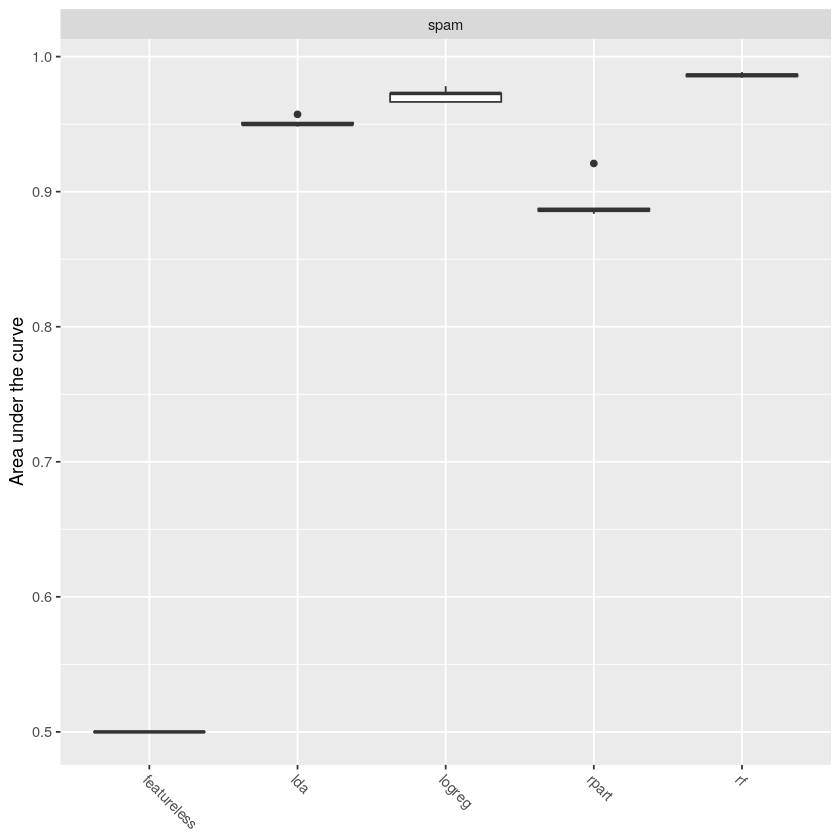

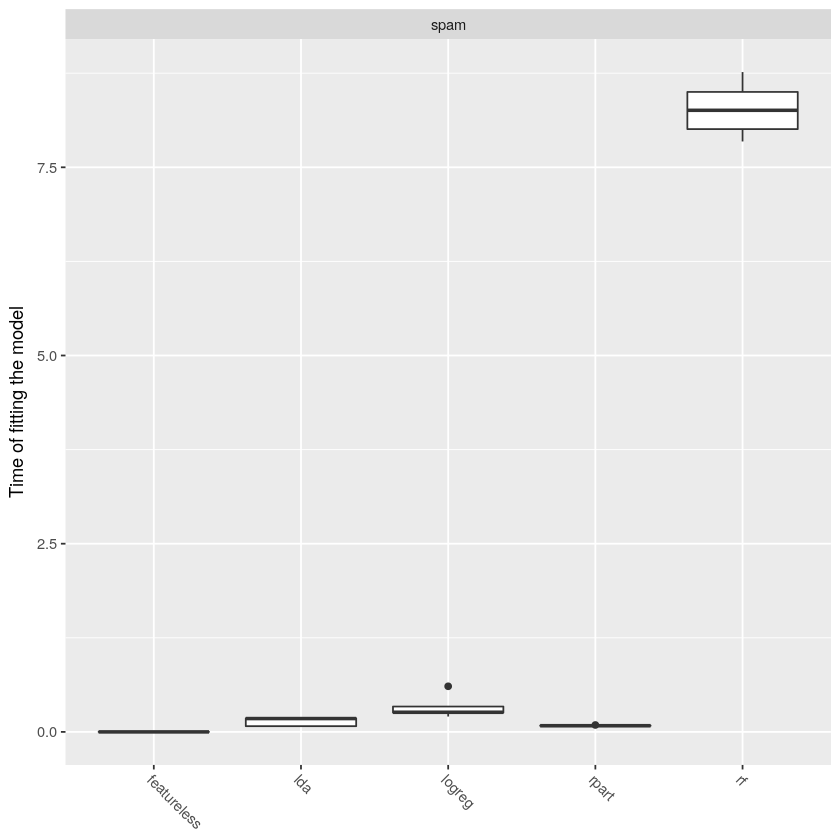

In [16]:
plotBMRBoxplots(bmr, measure = auc)
plotBMRBoxplots(bmr, measure = timetrain)

## Tuning 

Tune `mtry` and `nodesize` and `sampsize` of the random forest to get the best possible tuning error.

a) Define reasonable bounds for the parameter space. (Hint: Have a look at the number of rows and columns of the spam data)

b) Use a random search to optimize over the parameter space.

c) Why can't you directly compare the error of the tuned model with the results of benchmark? What should you do instead?

In [19]:
n = getTaskSize(spam.task)
p = getTaskNFeats(spam.task)
ps = makeParamSet(
    makeIntegerParam("mtry", lower = 1, upper = p),
    makeIntegerParam("nodesize", lower = 10, upper = 0.2 * n),
    makeIntegerParam("sampsize", lower = 1, upper = 0.6 * n)
)

tune.control = makeTuneControlRandom(maxit = 10)
lrn = makeLearner("classif.randomForest", predict.type = "prob")

res = tuneParams(lrn, spam.task, hout, auc, ps, tune.control)


[Tune] Started tuning learner classif.randomForest for parameter set:
            Type len Def        Constr Req Tunable Trafo
mtry     integer   -   -       1 to 57   -    TRUE     -
nodesize integer   -   -     10 to 920   -    TRUE     -
sampsize integer   -   - 1 to 2.76e+03   -    TRUE     -
With control class: TuneControlRandom
Imputation value: -0
[Tune-x] 1: mtry=10; nodesize=867; sampsize=2263
[Tune-y] 1: auc.test.mean=0.9518; time: 0.0 min
[Tune-x] 2: mtry=27; nodesize=509; sampsize=1310
[Tune-y] 2: auc.test.mean=0.9492; time: 0.0 min
[Tune-x] 3: mtry=18; nodesize=171; sampsize=1850
[Tune-y] 3: auc.test.mean=0.9661; time: 0.1 min
[Tune-x] 4: mtry=19; nodesize=745; sampsize=654
[Tune-y] 4: auc.test.mean=0.9383; time: 0.0 min
[Tune-x] 5: mtry=25; nodesize=360; sampsize=965
[Tune-y] 5: auc.test.mean=0.9513; time: 0.0 min
[Tune-x] 6: mtry=21; nodesize=604; sampsize=452
[Tune-y] 6: auc.test.mean=0.9383; time: 0.0 min
[Tune-x] 7: mtry=34; nodesize=314; sampsize=1668
[Tune-y] 7: auc

Tune result:
Op. pars: mtry=18; nodesize=171; sampsize=1850
auc.test.mean=0.9661